In [1]:
import os, math
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
from IPython.display import display, HTML

Throughput for Detock final-no per MH:
- {0.0: '51072.05', 0.1: '45413.60', 0.2: '41979.83', 0.5: '27680.07', 1.0: '11568.35', 2.0: '5152.58', 5.0: '2004.85', 10.0: '591.27'}
Throughput for slog final-no per MH:
- {0.0: '48813.05', 0.1: '47801.23', 0.2: '46506.10', 0.5: '38912.18', 1.0: '22893.80', 2.0: '10824.05', 5.0: '2985.90', 10.0: '900.07'}
Throughput for calvin final-no per MH:
- {0.0: '45406.18', 0.1: '43911.05', 0.2: '39809.77', 0.5: '32922.55', 1.0: '22679.57', 2.0: '10943.57', 5.0: '3089.78', 10.0: '914.08'}
Throughput for janus final-no per MH:
- {0.0: '21009.10', 0.1: '20395.82', 0.2: '18782.28', 0.5: '13972.60', 1.0: '8844.28', 2.0: '4747.95', 5.0: '1570.65', 10.0: '372.82'}


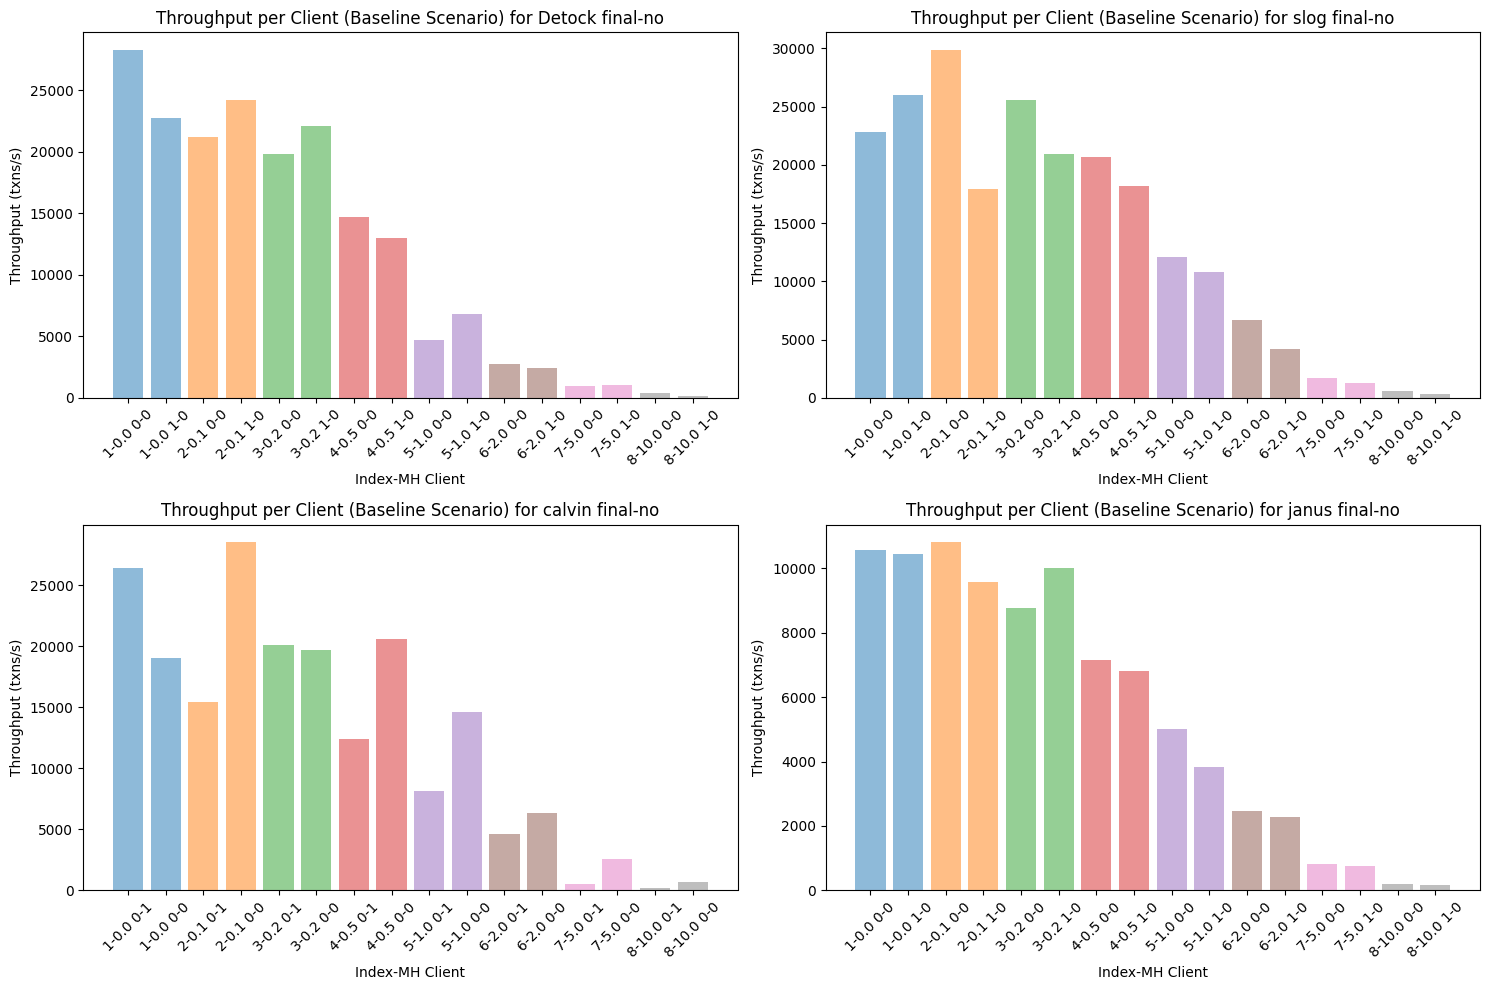

In [2]:
# Baseline Scenario Throughput Analysis

# Variables that need to be set
trials = {
    "Detock":  ["final-no"],
    "slog": ["final-no"],
    "calvin": ["final-no"],
    "janus": ["final-no"],
}
scenario = "packet_loss"
cols = 2
rows = int(np.ceil(sum([len(x) for x in trials.values()]) / cols))

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()  

i = 0
for db in trials.keys():
    for trial_tag in trials[db]:    
        # Collect throughput data
        mhs = defaultdict(dict)
        base_dir = f"../../data/pps/{scenario}/{trial_tag}/{db}"
        for experiment in os.listdir(base_dir):
            mh = float(experiment.split("-")[-1])
            index = int(experiment.split("-")[0])
            current = {}
            for client in os.listdir(f"{base_dir}/{experiment}/client"):
                if os.path.isdir(f"{base_dir}/{experiment}/client/{client}"):
                    metadata = pd.read_csv(f"{base_dir}/{experiment}/client/{client}/metadata.csv")
                    summary = pd.read_csv(f"{base_dir}/{experiment}/client/{client}/summary.csv")

                    duration = metadata["duration"].sum()
                    throughput = summary["committed"].sum() / duration
                    current[client] = throughput
            mhs[mh][index] = current

        # Plot the throughput for each experiment per client
        for mh in sorted(mhs.keys()):
            for index in sorted(mhs[mh].keys()):
                current = mhs[mh][index]
                axes[i].bar([f"{index}-{mh} {client}" for client in current.keys()], current.values(), alpha=0.5)
        axes[i].set_title(f"Throughput per Client (Baseline Scenario) for {db} {trial_tag}")
        axes[i].set_xlabel("Index-MH Client")
        axes[i].set_ylabel("Throughput (txns/s)")
        axes[i].tick_params(axis='x', rotation=45)

        # Print the total average throughput for each mh
        print(f"Throughput for {db} {trial_tag} per MH:")
        throughput = {}
        for mh in sorted(mhs.keys()):
            total = 0
            for index in sorted(mhs[mh].keys()):
                current = mhs[mh][index]
                total += sum(current.values())
            throughput[mh] = total / len(mhs[mh])
        print("-", {mh: f"{v:.2f}" for mh, v in throughput.items()})

        i += 1
plt.tight_layout()
plt.show()

Detock {0.1: 2.0234925407058224, 0.01: 1.0163934222988127, 0.0001: 0.642230816900113, 0.0: 0.6513864949165245, 1.0: 2.595179194849938, 0.5: 2.5394793455874063, 0.001: 0.6474495391052767}
slog {0.1: 2.056181321965262, 0.01: 1.044855548609647, 0.0001: 0.664636774039431, 0.0: 0.6580268536975042, 1.0: 2.656075861549991, 0.5: 2.589458096353207, 0.001: 0.665364544569766}
calvin {0.1: 1.9862186621158693, 0.01: 0.9436276689535298, 0.0001: 0.6166780304755194, 0.0: 0.6361580409629765, 1.0: 2.518238089091153, 0.5: 2.516557169620759, 0.001: 0.6269369244853851}
janus {0.1: 1.5263186944394513, 0.01: 0.7654727722578428, 0.0001: 0.49545788004139973, 0.0: 0.4721023674582965, 1.0: 2.006541360783389, 0.5: 1.9628591746624962, 0.001: 0.4923163388249202}


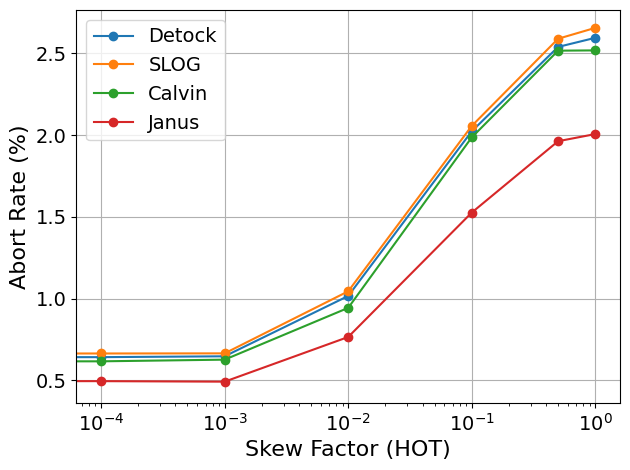

In [3]:
# Skew Scenario Abort Rate Analysis

# Variables that need to be set
scenario = "skew"
dbs = ["Detock", "slog", "calvin", "janus"]
db_name = ["Detock", "SLOG", "Calvin", "Janus"]
trial = "final-no"

# Collect abort rate data
abort_rates = defaultdict(dict)
for db in dbs:
    base_dir = f"../../data/pps/{scenario}/{trial}/{db}"
    for experiment in os.listdir(base_dir):
        skew = float(experiment.split("-")[-1])
        index = int(experiment.split("-")[0])
        current = {}
        for client in os.listdir(f"{base_dir}/{experiment}/client"):
            if os.path.isdir(f"{base_dir}/{experiment}/client/{client}"):
                metadata = pd.read_csv(f"{base_dir}/{experiment}/client/{client}/metadata.csv")
                summary = pd.read_csv(f"{base_dir}/{experiment}/client/{client}/summary.csv")

                throughput = summary["committed"].sum()
                aborts = summary["not_started"].sum()
                current[client] = aborts / throughput * 100
        abort_rates[db][skew] = np.mean(list(current.values()))
    print(db, abort_rates[db])

# Plot the abort rates
for db in abort_rates.keys():
    skews = sorted(abort_rates[db].keys())
    rates = [abort_rates[db][skew] for skew in skews]
    plt.plot(skews, rates, marker='o', label=db_name[dbs.index(db)])
plt.xlabel("Skew Factor (HOT)", fontsize=16)
plt.ylabel("Abort Rate (%)", fontsize=16)
plt.xscale('log')
plt.tick_params(axis='both', labelsize=14)
plt.legend(fontsize=14, title_fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.savefig("../../plots/output/pps/abort-rates.pdf", format="pdf", bbox_inches="tight")
plt.savefig("../../plots/output/pps/abort-rates.jpg", format="jpg", bbox_inches="tight")
plt.show()

109
109
108
109


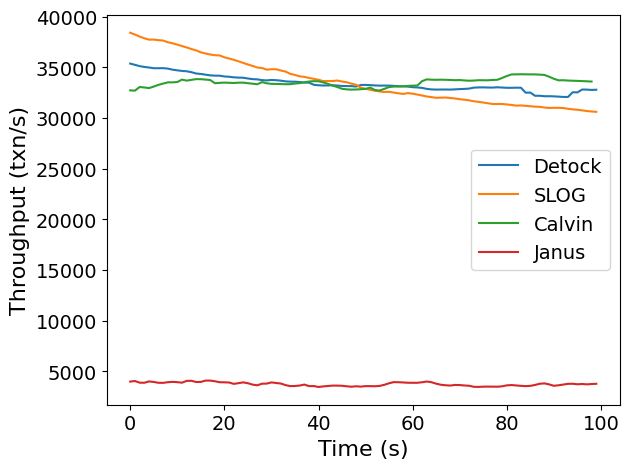

In [5]:
# Sunflower Scenario Throughput Analysis

# Variables that need to be set
scenario = "sunflower"
dbs = ["Detock", "slog", "calvin", "janus"]
db_name = ["Detock", "SLOG", "Calvin", "Janus"]
trial = "final-no"
experiment = "1-0"
start = 5
end = 5

def moving_average(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Collect throughput data
for db in dbs:
    base_dir = f"../../data/pps/{scenario}/{trial}/{db}/{experiment}"
    throughput = {}
    for client in os.listdir(f"{base_dir}/raw_logs"):
        if client.startswith("benchmark_container"):
            with open(f"{base_dir}/raw_logs/{client}", "r") as f:
                log_data = f.readlines()
            log_data = [line.strip() for line in log_data if "C: " in line]
            throughput[client] = np.array([float(line.split("C: ")[1].split(" ")[0]) for line in log_data if "C: " in line])
            throughput[client] = throughput[client][start:(len(throughput[client]) - end)]
            smoothed = moving_average(throughput[client], window_size=10)
            # plt.plot(smoothed, label=client)
    min_length = min(len(v) for v in throughput.values())
    print(min_length)
    for client in throughput.keys():
        throughput[client] = throughput[client][:min_length]
    total_throughput = np.sum(list(throughput.values()), axis=0)
    window_size = 10
    smoothed = moving_average(total_throughput, window_size=window_size)
    plt.plot(smoothed, label=db_name[dbs.index(db)])
plt.legend(fontsize=14, title_fontsize=16)
plt.xlabel("Time (s)", fontsize=16)
plt.ylabel("Throughput (txn/s)", fontsize=16)
plt.tick_params(axis='both', labelsize=14)
plt.tight_layout()
plt.savefig("../../plots/output/pps/sunflower-throughput.pdf", format="pdf", bbox_inches="tight")
plt.savefig("../../plots/output/pps/sunflower-throughput.jpg", format="jpg", bbox_inches="tight")
plt.show()

In [21]:
# Baseline Scenario Transaction Latency Analysis

# Variables that need to be set
sample_size = 50

base_dir = f"../../try"

transactions_file = f"{base_dir}/transactions.csv"
transactions = pd.read_csv(transactions_file)
print(len(transactions), "transactions loaded from", transactions_file)
for i in range(20000, 20000 + min(sample_size, len(transactions))):
    transaction = transactions.iloc[i]
    sent_at = transaction["sent_at"]
    received_at = transaction["received_at"]
    regions = transaction["regions"]
    partitions = transaction["partitions"]
    coordinator = transaction["coordinator"]
    latency = (received_at - sent_at) / 1_000_000
    code = transaction["code"]
    txn_type = code.split(";")[0]
    print(f"Transaction {i} {code}: Latency: {latency:.2f} ms, Regions: {regions}, Partitions: {partitions}, Coordinator: {coordinator}")

FileNotFoundError: [Errno 2] No such file or directory: '../../try/transactions.csv'

In [43]:
# Baseline Scenario Transaction Latency Analysis

# Variables that need to be set
trial_tag = "final-no"
db = "janus"
sample_size = 50
experiment = "4-30"

base_dir = f"../../data/pps/baseline/{trial_tag}/{db}/{experiment}"
index = int(experiment.split("-")[0])
mh = int(experiment.split("-")[1])

clients = {}
for client in os.listdir(f"{base_dir}/client"):
    if os.path.isdir(f"{base_dir}/client/{client}"):
        print(f"Client {client}")
        transactions = pd.read_csv(f"{base_dir}/client/{client}/transactions.csv", dtype={"regions": str, "partitions": str})
        clients[client] = []
        for i in range(0, min(sample_size, len(transactions))):
            transaction = transactions.iloc[i]
            sent_at = transaction["sent_at"]
            received_at = transaction["received_at"]
            regions = transaction["regions"]
            partitions = transaction["partitions"]
            coordinator = transaction["coordinator"]
            duration = received_at - sent_at
            if duration < 0:
                continue
            latency = (received_at - sent_at) / 1_000_000
            clients[client].append(latency)
            code = transaction["code"]
            txn_type = code.split(";")[0]
            print(f"Transaction {i} {code}: Latency: {latency:.2f} ms, Regions: {regions}, Partitions: {partitions}, Coordinator: {coordinator}")

Client 0-0
Transaction 0 order_product;300;2890;1610;2012;6652;8616;8338;3564;5052;4026;8546: Latency: 2314.38 ms, Regions: nan, Partitions: 1, Coordinator: 1
Transaction 1 get_parts_by_product;4086: Latency: 103.99 ms, Regions: nan, Partitions: 1, Coordinator: 0
Transaction 2 get_parts_by_product;1730: Latency: 797.83 ms, Regions: nan, Partitions: 1, Coordinator: 1
Transaction 3 get_parts_by_product;4401: Latency: 103.40 ms, Regions: nan, Partitions: 0, Coordinator: 1
Transaction 4 get_parts_by_product;3346: Latency: 198.97 ms, Regions: nan, Partitions: 1, Coordinator: 0
Transaction 5 get_parts_by_product;4897: Latency: 425.32 ms, Regions: nan, Partitions: 0, Coordinator: 0
Transaction 6 get_parts_by_product;4257: Latency: 214.36 ms, Regions: nan, Partitions: 0, Coordinator: 1
Transaction 7 get_part;5015: Latency: 471.03 ms, Regions: nan, Partitions: 0, Coordinator: 0
Transaction 9 order_product;2402;430;2222;5806;8070;1302;7354;2634;854;7114;5790: Latency: 113.67 ms, Regions: nan, Pa

{'0-0': [2314.376182, 103.991232, 797.82691, 103.401217, 198.965718, 425.324096, 214.358768, 471.033647, 113.667092, 773.843822, 126.471673, 1214.71967, 103.329582, 406.215341, 2212.456654, 1814.973814, 247.98249, 105.538575, 1389.420365, 504.786594, 206.541132, 2585.928636, 112.092336, 268.934033, 235.15532, 1208.363173, 119.685682, 108.803924, 245.756554, 482.533767, 107.163043, 214.700435, 104.686516, 112.232632, 104.831599, 621.040574, 1446.306762, 2722.64964, 103.04722, 510.827116, 104.232328, 9052.78508, 181.508748, 451.642984, 301.373018, 160.908049, 107.629305, 484.378599, 941.383559], '1-0': [315.635793, 3840.115365, 2880.579901, 1721.230856, 2968.837304, 1221.497119, 6414.571368, 2435.324307, 2438.335942, 2778.707107, 3449.7571, 1068.925571, 1967.932108, 3795.914245, 3426.282342, 2225.24385, 1636.490009, 3624.930136, 1227.18379, 5124.65521, 1113.718833, 2167.000105, 3433.037579, 6388.6341, 8419.857748, 958.490878, 2687.021157, 2998.665199, 3673.348173, 10646.816718, 3692.8750

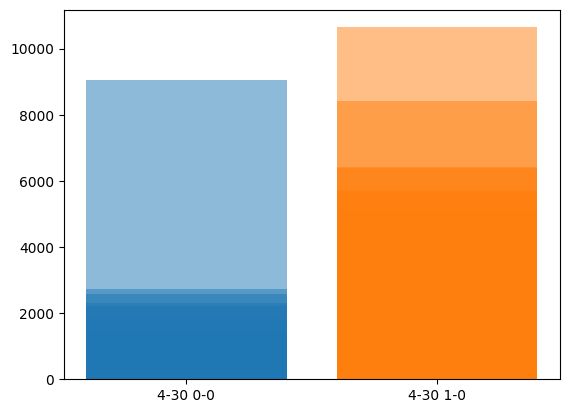

In [44]:
for client, latencies in clients.items():
    plt.bar([f"{index}-{mh} {client}"] * len(latencies), latencies, alpha=0.5)
print(clients)

In [3]:
# Baseline Scenario Transaction Types and Involved Regions/Partitions Analysis

# Variables that need to be set
trial_tag = "final-2"
db = "Detock"
sample_size = 10000
experiments_per_mh = 1

base_dir = f"../../data/pps/baseline/{trial_tag}/{db}"
results = defaultdict(dict)
for experiment in os.listdir(base_dir):
    index = int(experiment.split("-")[0])
    mh = int(experiment.split("-")[1])
    results[mh][index] = defaultdict(dict)
    for client in os.listdir(f"{base_dir}/{experiment}/client"):
        if os.path.isdir(f"{base_dir}/{experiment}/client/{client}"):
            transactions = pd.read_csv(f"{base_dir}/{experiment}/client/{client}/transactions.csv", dtype={"regions": str, "partitions": str})
            for i in range(0, min(sample_size, len(transactions))):
                transaction = transactions.iloc[i]
                txn_type = transaction["code"].split(";")[0]
                if txn_type not in results[mh][index][client]:
                    results[mh][index][client][txn_type] = {
                        "total": 0,
                        "aborted": 0,
                        "involved_regions": defaultdict(int),
                        "involved_partitions": defaultdict(int)
                    }
                results[mh][index][client][txn_type]["total"] += 1
                involved_regions = transaction["regions"]
                involved_partitions = transaction["partitions"]
                if (involved_regions == "" or \
                    (isinstance(involved_regions, float) and math.isnan(involved_regions)) or \
                    (isinstance(involved_regions, str) and involved_regions.lower() == "nan")):
                    results[mh][index][client][txn_type]["aborted"] += 1
                else:
                    results[mh][index][client][txn_type]["involved_regions"][frozenset(involved_regions.split(";"))] += 1
                    results[mh][index][client][txn_type]["involved_partitions"][frozenset(involved_partitions.split(";"))] += 1
            print(f"Processed {client} for MH {mh} Index {index}: {results[mh][index][client]}")

Processed 0-0 for MH 20 Index 3: {'order_product': {'total': 4465, 'aborted': 80, 'involved_regions': defaultdict(<class 'int'>, {frozenset({'0'}): 3498, frozenset({'0', '1'}): 887}), 'involved_partitions': defaultdict(<class 'int'>, {frozenset({'0', '1'}): 2215, frozenset({'1'}): 1119, frozenset({'0'}): 1051})}, 'get_parts_by_product': {'total': 4861, 'aborted': 0, 'involved_regions': defaultdict(<class 'int'>, {frozenset({'1'}): 462, frozenset({'0'}): 4399}), 'involved_partitions': defaultdict(<class 'int'>, {frozenset({'1'}): 2435, frozenset({'0'}): 2426})}, 'get_product': {'total': 117, 'aborted': 0, 'involved_regions': defaultdict(<class 'int'>, {frozenset({'0'}): 101, frozenset({'1'}): 16}), 'involved_partitions': defaultdict(<class 'int'>, {frozenset({'0'}): 58, frozenset({'1'}): 59})}, 'get_part': {'total': 116, 'aborted': 0, 'involved_regions': defaultdict(<class 'int'>, {frozenset({'1'}): 58, frozenset({'0'}): 58}), 'involved_partitions': defaultdict(<class 'int'>, {frozenset

In [4]:

# Create a table showing the transaction types, total transactions, aborted transactions, and involved regions/partitions
experiments = [f"{index}-{mh}" for mh in sorted(results.keys()) for index in sorted(results[mh].keys())]
clients = sorted(set(client for mh in results.values() for index in mh.keys() for client in mh[index].keys()))
txn_types = sorted(set(txn_type for mh in results.values() for index in mh.keys() for client in mh[index].keys() for txn_type in mh[index][client].keys()))
row_tuples = [(experiment, client, txn_type) for experiment in experiments for client in clients for txn_type in txn_types]
row_index = pd.MultiIndex.from_tuples(row_tuples, names=["Experiment", "Client", "Transaction Type"])

regions = sorted(set(region for mh in results.values() for index in mh.keys() for client in mh[index].keys() for txn_type in mh[index][client].keys() for region in mh[index][client][txn_type]["involved_regions"].keys()))
partitions = sorted(set(partition for mh in results.values() for index in mh.keys() for client in mh[index].keys() for txn_type in mh[index][client].keys() for partition in mh[index][client][txn_type]["involved_partitions"].keys()))
col_tuples = []
col_tuples.append(("Total", ""))
col_tuples.append(("Aborted", ""))
for region in regions:
    col_tuples.append(("Regions", region))
for partition in partitions:
    col_tuples.append(("Partitions", partition))
col_index = pd.MultiIndex.from_tuples(col_tuples, names=["Metric", "Detail"])

# Create a DataFrame to hold the results
data = []
for experiment in experiments:
    index, mh = map(int, experiment.split("-"))
    for client in clients:
        for txn_type in txn_types:
            total = results[mh][index][client].get(txn_type, {}).get("total", 0)
            aborted = results[mh][index][client].get(txn_type, {}).get("aborted", 0)
            regions_data = results[mh][index][client].get(txn_type, {}).get("involved_regions", {})
            partitions_data = results[mh][index][client].get(txn_type, {}).get("involved_partitions", {})
            row = [total, aborted]
            for region in regions:
                row.append(regions_data.get(region, 0))
            for partition in partitions:
                row.append(partitions_data.get(partition, 0))
            data.append(row)
df = pd.DataFrame(data, index=row_index, columns=col_index)

display(HTML(f"<div style=\"max-height: 1000px; overflow-y: auto; overflow-x: auto;\">{df.to_html()}</div>"))

In [7]:
# Baseline Scenario Record Access Analysis

# Variables that need to be set
trial_tag = "meeting"
samples = 10000
db = "Detock"

base_dir = f"../../data/pps/baseline/{trial_tag}/{db}"
experiments = os.listdir(base_dir)
experiments = sorted(experiments, key=lambda x: int(x.split("-")[-1]))

record_access = {}
for i, experiment in enumerate(experiments):
    print(f"Processing {experiment}...")
    # Collecting transaction codes
    codes = {}
    for client in os.listdir(f"{base_dir}/{experiment}/client"):
        if os.path.isdir(f"{base_dir}/{experiment}/client/{client}"):
            transactions = pd.read_csv(f"{base_dir}/{experiment}/client/{client}/transactions.csv")
            codes[client] = transactions["code"].tolist()[:samples]

    # Collecting product access data for get_parts_by_product
    gpbp_type = {}
    for client in codes.keys():
        gpbp_type[client] = []
        for code in codes[client]:
            type = code.split(";")[0]
            if type == "get_parts_by_product":
                gpbp_type[client].append(int(code.split(";")[1]))
    record_access[experiment] = gpbp_type

Processing 1-0...
Processing 2-10...
Processing 3-20...
Processing 4-30...
Processing 5-40...
Processing 6-50...
Processing 7-60...
Processing 8-70...
Processing 9-80...
Processing 10-90...
Processing 11-100...


In [32]:
# Variables that need to be set
num_regions = 2
num_partitions = 2
num_categories = 4

# Compute the categories of the accessed products and their counts
for experiment, gpbp_type in record_access.items():
    print(f"Experiment: {experiment}")
    for client, product_ids in gpbp_type.items():
        results = {category: defaultdict(Counter) for category in range(num_categories)}
        for product_id in product_ids:
            category = ((product_id - 1) % (num_regions * num_partitions * 4)) // (num_regions * num_partitions)
            chosen_region = (((product_id - 1) % (num_regions * num_partitions * 4)) % (num_regions * num_partitions)) // num_partitions
            chosen_partition = (((product_id - 1) % (num_regions * num_partitions * 4)) % (num_regions * num_partitions)) % num_partitions
            chosen_block_within_cateogory = (product_id - 1)  // (num_regions * num_partitions * 4)
            results[category][(chosen_region, chosen_partition)][chosen_block_within_cateogory] += 1
        print("- Client:", client)
        for category, result in results.items():
            print(f"-- Category {category}:")
            for (region, partition) in sorted(result.keys()):
                counts = result[(region, partition)]
                print(f"--- ({region}, {partition}):", sum(counts.values()), counts.most_common(5))


Experiment: 1-0
- Client: 0-0
-- Category 0:
--- (0, 0): 768 [(109, 8), (95, 8), (290, 8), (142, 7), (113, 6)]
--- (0, 1): 780 [(224, 9), (104, 9), (295, 8), (61, 7), (103, 7)]
--- (1, 0): 767 [(134, 8), (161, 7), (83, 7), (241, 7), (266, 7)]
--- (1, 1): 776 [(8, 8), (55, 7), (168, 6), (48, 6), (129, 6)]
-- Category 1:
--- (0, 0): 730 [(214, 8), (29, 7), (164, 7), (268, 6), (174, 6)]
--- (0, 1): 767 [(96, 8), (198, 8), (27, 7), (107, 7), (190, 6)]
--- (1, 0): 816 [(137, 9), (258, 9), (64, 8), (117, 8), (113, 7)]
--- (1, 1): 739 [(261, 9), (302, 8), (62, 7), (178, 6), (0, 6)]
-- Category 2:
-- Category 3:
- Client: 1-0
-- Category 0:
--- (0, 0): 753 [(20, 8), (298, 6), (213, 6), (190, 6), (268, 6)]
--- (0, 1): 772 [(95, 8), (81, 8), (120, 8), (223, 7), (175, 7)]
--- (1, 0): 731 [(80, 8), (138, 6), (184, 6), (28, 6), (282, 6)]
--- (1, 1): 708 [(290, 7), (107, 7), (117, 6), (21, 6), (283, 6)]
-- Category 1:
--- (0, 0): 796 [(262, 7), (173, 7), (35, 7), (32, 7), (180, 7)]
--- (0, 1): 763 [

In [16]:
# Print the most common product IDs accessed by get_parts_by_product
for experiment, gpbp_type in record_access.items():
    print(f"Experiment: {experiment}")
    accessed = {}
    for client, product_ids in gpbp_type.items():
        accessed[client] = Counter(product_ids)
        print(f"-Client {client}: {accessed[client].most_common(10)}")
    average_accessed = defaultdict(int)
    for client, counts in accessed.items():
        for product_id, count in counts.items():
            average_accessed[product_id] += count
    average_accessed = {k: v / len(accessed) for k, v in average_accessed.items()}
    average_accessed_prod = sorted(average_accessed.items(), key=lambda x: x[1], reverse=True)
    print("-Average:", [f"({product_id}, {average_accessed[product_id]}) {[accessed[k][product_id] for k in accessed]}" for product_id, _ in average_accessed_prod[:10]])

Experiment: 1-0
-Client 0-0: [(4184, 9), (2199, 9), (4135, 9), (3586, 9), (1666, 9), (1745, 8), (132, 8), (4840, 8), (1542, 8), (3429, 8)]
-Client 1-0: [(3878, 9), (1522, 8), (1283, 8), (1816, 8), (2328, 8), (1298, 8), (321, 8), (22, 8), (1922, 8), (4197, 7)]
-Average: ['(1666, 7.5) [9, 6]', '(3878, 7.0) [5, 9]', '(4293, 6.0) [6, 6]', '(4840, 6.0) [8, 4]', '(4578, 6.0) [5, 7]', '(22, 6.0) [4, 8]', '(3586, 6.0) [9, 3]', '(1521, 6.0) [8, 4]', '(4641, 6.0) [8, 4]', '(1000, 5.5) [7, 4]']
Experiment: 2-10
-Client 0-0: [(4696, 10), (4690, 8), (4712, 8), (2178, 7), (692, 7), (919, 7), (3426, 7), (3364, 7), (3507, 7), (742, 7)]
-Client 1-0: [(2118, 9), (917, 8), (1073, 8), (23, 7), (4072, 7), (3559, 7), (3683, 7), (868, 7), (3382, 7), (1172, 7)]
-Average: ['(2118, 7.0) [5, 9]', '(437, 6.0) [6, 6]', '(8, 6.0) [6, 6]', '(1272, 5.5) [5, 6]', '(4456, 5.5) [5, 6]', '(3893, 5.5) [5, 6]', '(151, 5.5) [5, 6]', '(4690, 5.5) [8, 3]', '(3173, 5.5) [6, 5]', '(4696, 5.5) [10, 1]']
Experiment: 3-20
-Client 

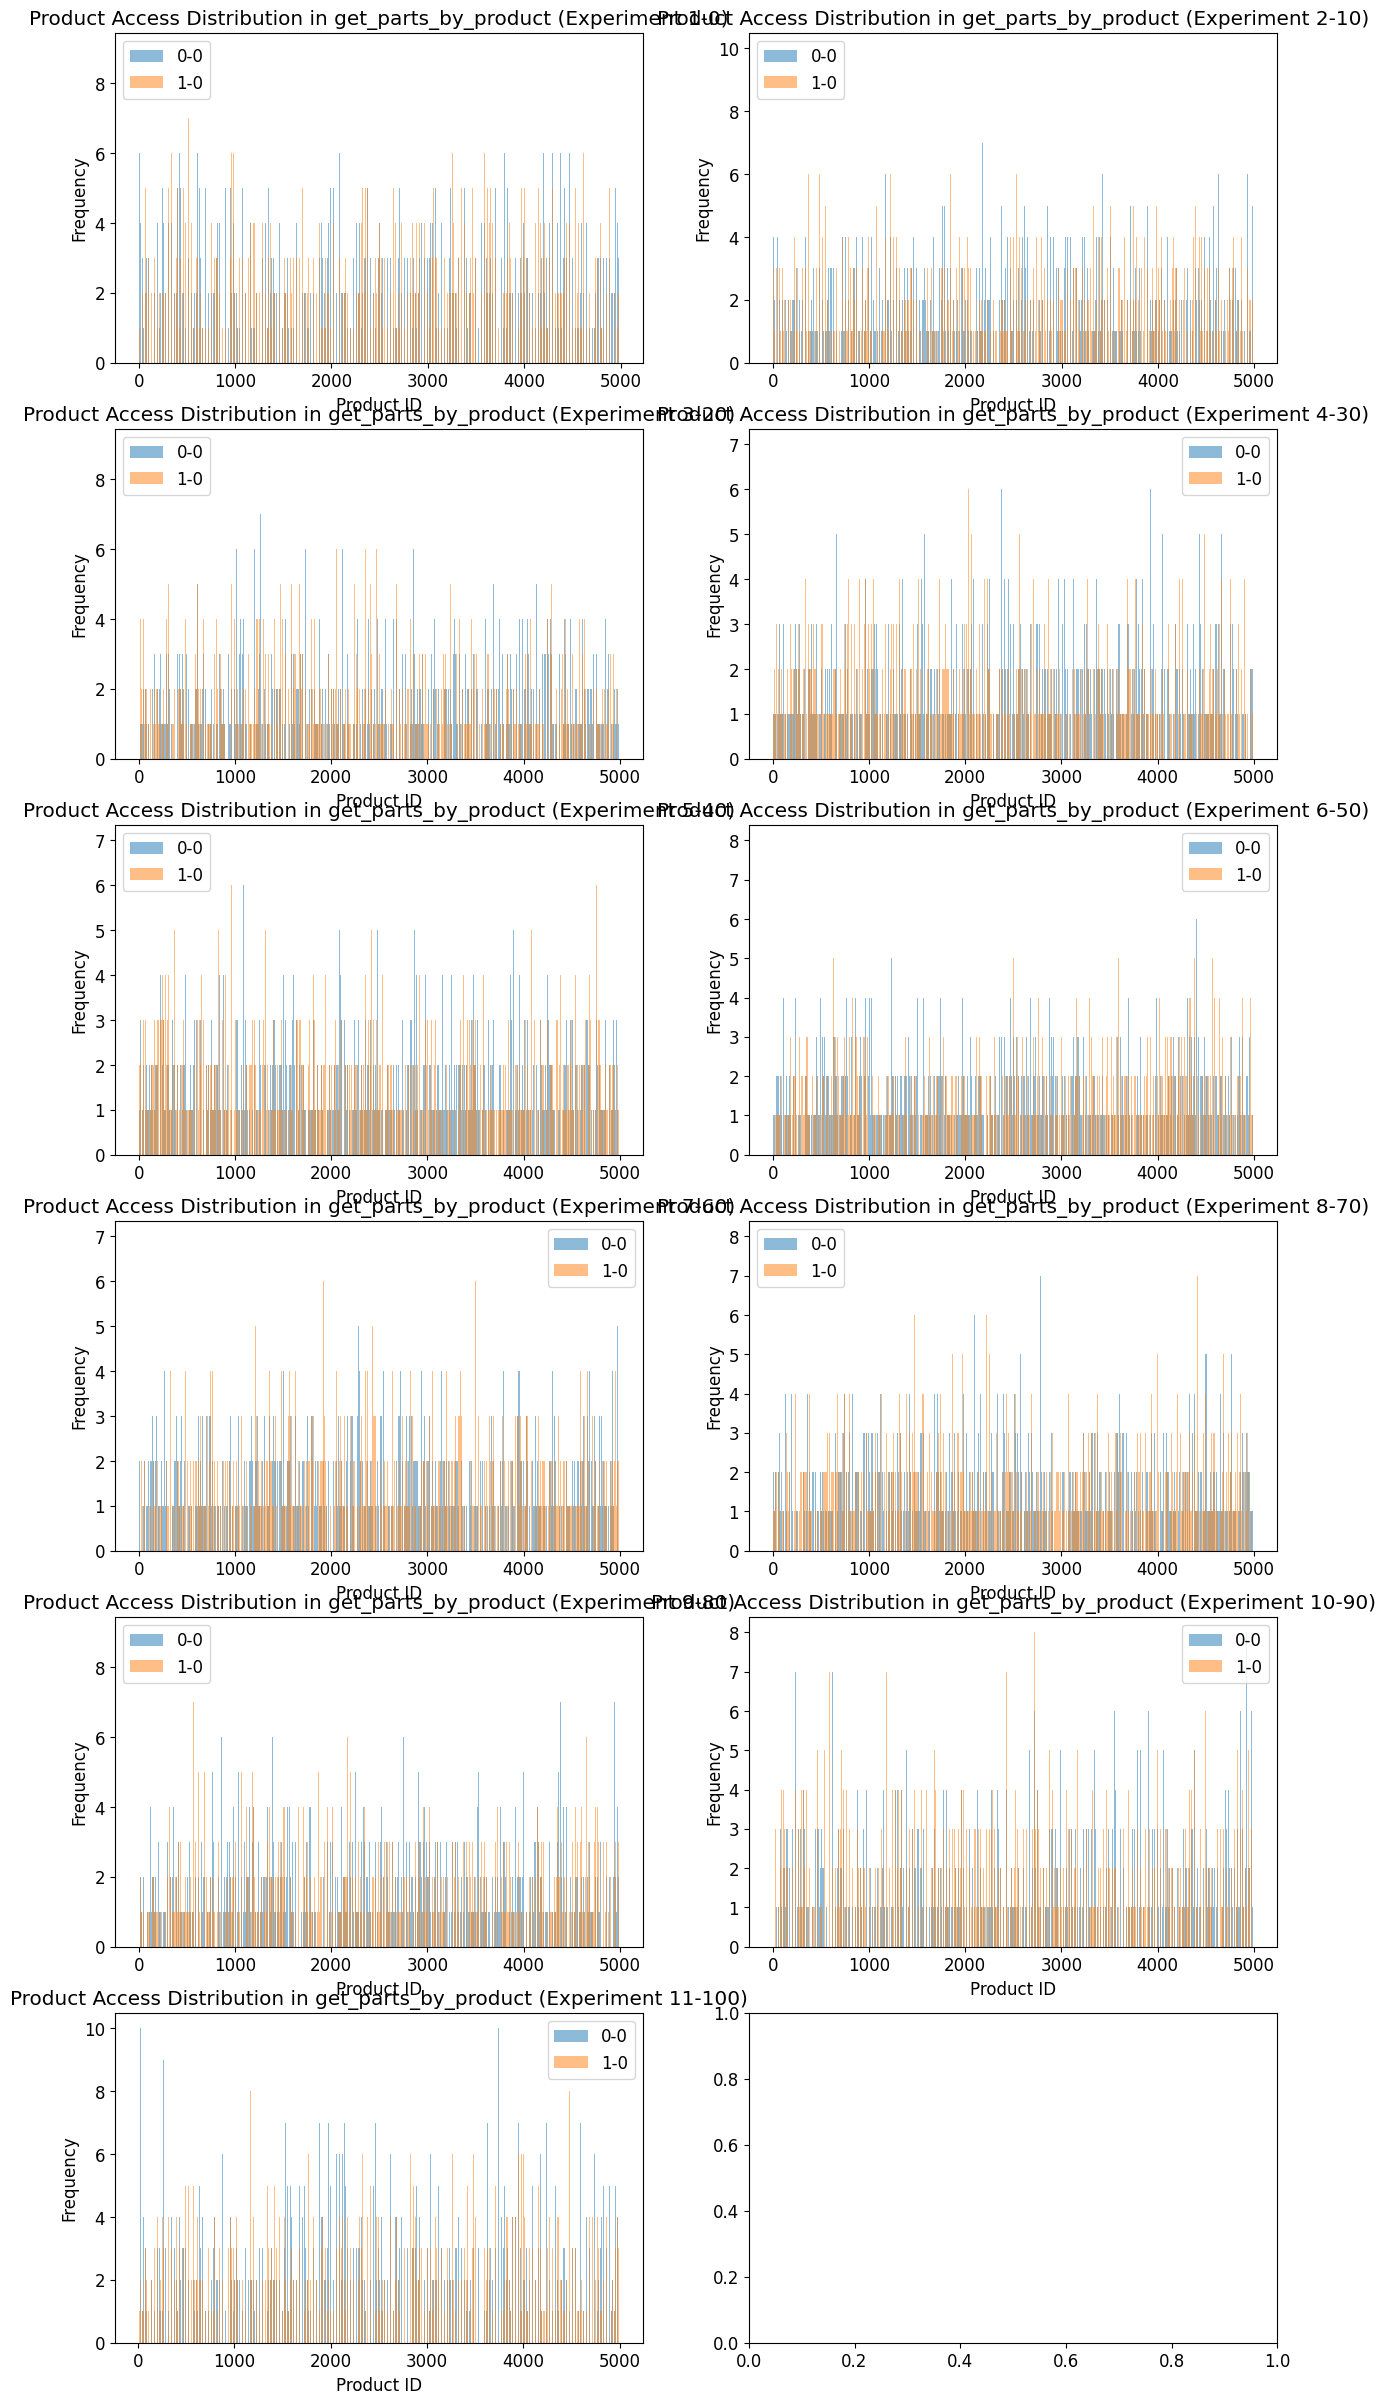

In [17]:
# Variables that need to be set
cols = 2

rows = int(np.ceil(len(experiments) / cols))
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()  

# Plot the product access distribution for each experiment for get_parts_by_product
for i, experiment in enumerate(experiments):
    gpbp_type = record_access[experiment]
    for j, client in enumerate(gpbp_type.keys()):
        mn = min(gpbp_type[client])
        mx = max(gpbp_type[client])
        axes[i].hist(gpbp_type[client], bins=range(mn, mx + 1), alpha=0.5, label=client)
    axes[i].set_title(f"Product Access Distribution in get_parts_by_product (Experiment {experiment})")
    axes[i].set_xlabel("Product ID")
    axes[i].set_ylabel("Frequency")
    axes[i].legend()
plt.tight_layout
plt.show()